# <center> Tarea ETL - Entendimiento </center>
Proceso de entendimiento de datos de WWImporters a través de perfilamiento general, análisis de reglas de negocio, estadísticos y análisis de calidad de datos. Se usara PySpark para realizar la exploración y calidad de datos sobre los datos de la tabla movimientosCopia que se encuentra en la base de datos WWImportersTransactional, que registra el movimiento en inventario de un producto. La empresa no compartió información de las tablas de clientes ni de proveedores para esta actividad.

                                                                                                Santiago Gutiérrez Hernández

## Configuración e importe de paquetes

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np

C:\Users\estudiante\AppData\Roaming\Python\Python39\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
C:\Users\estudiante\AppData\Roaming\Python\Python39\site-packages\visions\backends\shared\nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:
C:\Users\estudiante\AppData\Local\Temp\ipykernel_548\2355262383.py:11: DeprecationWarning: `import pand

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
db_connection_string = 'jdbc:mysql://157.253.236.116:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_51_202315'
db_psswd = 'aabb1122'

PATH='./'

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

## 1. Perfilamiento de datos

En esta etapa se realizara el entendimiento general de los datos, la alidación de reglas de negocio y análisis descriptivo utilizando estadística descriptiva y diagramas para la visualización de los datos y análisis de calidad.

#### En relación a los datos Wide World Importers menciona:

- La cantidad máxima de productos movidos es 50 millones por transacción
- Existen 236.668 movimientos de producto realizados desde 2013
- Los movimientos están relacionados con 228.265 clientes
- El formato de fechas manejado es YYYY-MM-DD HH:MM:SS
- Actualmente tenemos 13 proveedores

### 1.1 Entendimiento general de los datos

In [7]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

In [8]:
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

In [86]:
movimientos.show(50)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

Podemos observar en la tabla de movimientos tenemos información relacionada con el producto, cliente, el empleado y con información del movimiento. En general la mayoria de campos que cuentan con ID son llevas secundarias que nos ayudan a relacionarnos con otras tablas, ya sea del cliente, producto, proveedor, entre otras. La información del producto encontramos el "ProductoID", del cliente contamos con el "ClienteID", del proveedor con el "ProveedorID", de la factura "InvoiceID", de las ordenes la "OrdenesDeCompraID", y por ultimo de los movimientos contamos con la "TransaccionProductoID" (la llave primaria que identifica al movimiento), la "FechaTransaccion" y "Cantidad" (Cantidad de productos que se ingresaron/sacaron del inventario). 

In [14]:
movimientos.schema

StructType([StructField('TransaccionProductoID', IntegerType(), True), StructField('ProductoID', IntegerType(), True), StructField('TipoTransaccionID', IntegerType(), True), StructField('ClienteID', DoubleType(), True), StructField('InvoiceID', DoubleType(), True), StructField('ProveedorID', StringType(), True), StructField('OrdenDeCompraID', StringType(), True), StructField('FechaTransaccion', StringType(), True), StructField('Cantidad', DoubleType(), True)])

Por otra lado, al identificar el esquema de la tabla podemos identificar que los campos "TransaccionProductoID", "ProductoID", "TipoTransaccionID" son del tipo "Integer". Los campos "ClienteID", "InvoiceID" y "Cantidad" son del tipo "Double". Los campos "ProveedorID","OrdenDeCompraID" y "FechaTransaccion" son del tipo "String". Tenemos entonces 3 campos que son "Integer", 3 tipos "Double" y 3 tipo "String".

In [16]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9)


En total tenemos 204.292 movimientos y tenemos en total 9 variables a revisar. De las cuales, podemos decir que 8 son nùmericas y una es tipo fecha.

### 1.2 Revisión reglas de negocio

Ahora vamos a validar las reglas proporcionadas por el negocio.

#### 1.2.1 Cantidad máxima de productos movidos es 50 millones por transacción.

In [40]:
movimientos.agg({"Cantidad":"min"}).show()
movimientos.agg({"Cantidad":"mean"}).show()
movimientos.agg({"Cantidad":"max"}).show()

+-------------+
|min(Cantidad)|
+-------------+
|       -360.0|
+-------------+

+-----------------+
|    avg(Cantidad)|
+-----------------+
|719.4997650421946|
+-----------------+

+-------------+
|max(Cantidad)|
+-------------+
|      67368.0|
+-------------+



Al revisar los valores de la cantidad validamos que no encontramos valores superiores a los 50 millones. La maxima cantidad de productos que se encontro fue de 67.368 unidades. Podemos inferir que aun no tenemos registros de movimientos con cantidades de productos movidos sea igual a 50 millones por transacción. Se reviso el diccionario de campos de WWImporters para esta tabla y no especifican en que unidad de valor (ejemplo: decenas, centanas, miles o millones) estan las cifras, lo que seguimos infiriendo que las cifras estan en unidades. De igual modo, se debe revisar con negocio en que unidad de valor se encuentran las cifras, y de ser asi validar si los valores son correctos. Confirmado, validan nuestra primera inferencia y que la primera regla de negocio es cierta y qu eno hay registros qu tengan movimientos superiores a 50 millones por transaccion. 

#### 1.2.2 Existen 236.668 movimientos de producto realizados desde 2013

In [82]:
movimientos.agg({"FechaTransaccion":"min"}).show()
print("Hay un total de: " + str(movimientos.count()) + " regristros en la tabla de operaciones.")

+---------------------+
|min(FechaTransaccion)|
+---------------------+
| 2013-12-31 07:00:...|
+---------------------+

Hay un total de: 204292 regristros en la tabla de operaciones.


In [56]:
print("Encontramos una diferencia de: " +  str( 236668 - movimientos.count()) + " resgistros")

Encontramos una diferencia de: 32376 resgistros


Validamos el periodo en el que se encuentran los datos. La información empieza desde el 31 de diciembre de 2013. Surge un cuestionameinto, ya que para el 2013 solo se cuenta con información de una sola fecha. Por otro lado, se valida que el numero de registros que se tiene es inferior a la regla que presenta negocio. Se cuenta con una diferencia de 32.376 regitros. Por lo tanto, se concluir que esta regla de negocio no es cierta dado que el número de registros no coincidir con el número dado por el negocio, una primera intuición nos dice que podría faltar información y que tendriamso que validarlo con negocio.

#### 1.2.3 Los movimientos están relacionados con 228.265 clientes

In [66]:
clientes_unicos = movimientos.select("ClienteID").distinct().count()
print("Número de clientes distintos:", clientes_unicos)

movimientos.groupBy("ClienteID").count().show(1000)

Número de clientes distintos: 664
+---------+-----+
|ClienteID|count|
+---------+-----+
|    596.0|  315|
|    496.0|  316|
|    934.0|  307|
|    558.0|  385|
|   1051.0|   88|
|    170.0|  338|
|    184.0|  315|
|    810.0|  401|
|    147.0|  277|
|    576.0|  275|
|    160.0|  236|
|    169.0|  333|
|    994.0|  306|
|    486.0|  277|
|     70.0|  376|
|    571.0|  289|
|     67.0|  358|
|      8.0|  234|
|    878.0|  280|
|    818.0|  253|
|    168.0|  272|
|      0.0| 7156|
|    973.0|  271|
|     69.0|  320|
|    524.0|  294|
|    857.0|  329|
|    594.0|  263|
|    840.0|  279|
|    889.0|  300|
|    991.0|  294|
|    401.0|  346|
|    925.0|  246|
|      7.0|  303|
|    803.0|  327|
|    984.0|  322|
|    902.0|  304|
|    142.0|  307|
|    191.0|  312|
|    802.0|  322|
|    921.0|  286|
|    154.0|  290|
|    112.0|  317|
|    451.0|  287|
|    936.0|  298|
|    827.0|  312|
|   1047.0|  114|
|    521.0|  296|
|    879.0|  295|
|   1020.0|  269|
|    858.0|  275|
|    438.0| 

In [67]:
print("Encontramos una diferencia de: " +  str( 228265 - movimientos.select("ClienteID").distinct().count()) + " resgistros")

Encontramos una diferencia de: 227601 resgistros


El numero de clientes unicos es de 664. Por lo tanto, la regla de negocio no es cierta, ya que no coinciden el numero de clientes registros con el numero de clientes relacionados por negocio. Se cuenta con una diferencia de 227.601 clientes. 

#### 1.2.4 El formato de fechas manejado es YYYY-MM-DD HH:MM:SS

In [70]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de ordenes: "+str(movimientos.count())+", número de ordenes con formato correcto: "+str(cumplenFormato.count()))

Número total de ordenes: 204292, número de ordenes con formato correcto: 140038


In [71]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
|     Dec 10,2015|
|     Dec 04,2015|
|     Dec 23,2015|
|     Jul 27,2015|
|     Sep 15,2014|
|     Aug 04,2015|
|     Feb 23,2015|
|     May 01,2015|
|     Jan 08,2016|
|     Mar 26,2014|
|     Jul 31,2015|
|     Sep 02,2014|
|     Mar 15,2016|
|     May 28,2016|
|     Sep 09,2015|
|     May 23,2014|
|     Aug 20,2014|
|     Jan 21,2015|
|     Dec 29,2015|
+----------------+
only showing top 20 rows



(64254, None)

Hay 64.254 registros cuya fecha no cumple con el formato especificado. Sin embargo, los valores que son diferentes parecen serlo solo porque varia el formato, este tipo de casos pueden ser solucionados fácilmente. Se le notificaria a negocio.

#### 1.2.4 Actualmente tenemos 13 proveedores

In [75]:
movimientos.groupBy("ProveedorID").count().show()
distinct_provider_count = movimientos.select("ProveedorID").distinct().count()
print("Número de proveedores distintos:", distinct_provider_count)

+-----------+------+
|ProveedorID| count|
+-----------+------+
|        1.0|    11|
|        4.0|  4832|
|        7.0|  2267|
|           |197182|
+-----------+------+

Número de proveedores distintos: 4


Tenemos un total de 3 provedores, los demas salen en blanco. Por lo tanto, la regla de negocio no es cierta, ya que no coinciden el numero de proveedores de la tabla con el numero de proveedores que relaciona negocio. Hay una diferencia de 10 proveedores.

## 2. Análisis Descriptivo

In [77]:
movimientos.summary().show()

+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|summary|TransaccionProductoID|        ProductoID|  TipoTransaccionID|         ClienteID|        InvoiceID|      ProveedorID|   OrdenDeCompraID|    FechaTransaccion|         Cantidad|
+-------+---------------------+------------------+-------------------+------------------+-----------------+-----------------+------------------+--------------------+-----------------+
|  count|               204292|            204292|             204292|            204292|           204292|           204292|            204292|              204292|           204292|
|   mean|   212458.04047637695|110.70090850351458| 10.035253460732676| 517.3252941867523|42957.26929590978|4.951898734177215|1345.9973277074544|                NULL|719.4997650421946|
| stddev|    71352.37579752573| 63.49014746219581|0.18563716955046372|353.501369

La "Cantidad" maxima que han retirado es de 360 unidades, y la cantidad maxima que han igresado es de 67.368 unidades. Se presenta una cantidad media de 719,5 unidades y una mediana de -9 unidades, ya nos da un indicio de que hay una gran variabilidad entre los datos y que lo mas probable es que no sigan una distribución normal. Cuando revisamos la desviación estandar, igual a 4.729 unidades aprox, nos confirma la premisa anterior e identificamos que hay una gran variabilidad entre los datos. El percentil nos indica que el 75% de los datos no sobrepasan el valor de -5, ya nos muestra la presencia de valores anomalos o extremos.

{'whiskers': [<matplotlib.lines.Line2D at 0x161e108dca0>,
 'caps': [<matplotlib.lines.Line2D at 0x161dfd63220>,
 'boxes': [<matplotlib.lines.Line2D at 0x161e108da00>],
 'medians': [<matplotlib.lines.Line2D at 0x161e108d700>],
 'fliers': [<matplotlib.lines.Line2D at 0x161dfd63760>],
 'means': []}

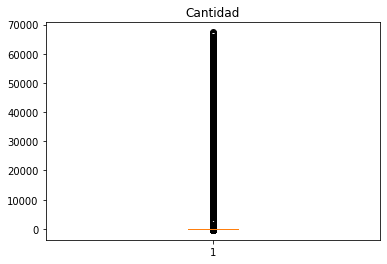

In [79]:
fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad')

my_list = [float(i) for i in movimientos.select(f.collect_list('Cantidad')).first()[0]]
ax1.boxplot(my_list)

Terminamos de confirmar la presencia de varios valores anomalos o extremos. En general los demas campos son llaves que sirven para relacionar con otras tablas. Pero podriamos sacar la moda a traves de una tabla de frecuencuas de alguna de ellas. Podemos identificar como se estan agrupando los datos y donde hay mayores concentraciones.

In [92]:
movimientos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)
movimientos.groupby("ProductoID").count().orderBy("count", ascending=False).show(10)
movimientos.groupby("ClienteID").count().orderBy("count", ascending=False).show(10)
movimientos.groupby("TipoTransaccionID").count().orderBy("count", ascending=False).show(10)
movimientos.groupby("OrdenDeCompraID").count().orderBy("count", ascending=False).show(10)
movimientos.groupby("FechaTransaccion").count().orderBy("count", ascending=False).show(10)

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+

+----------+-----+
|ProductoID|count|
+----------+-----+
|        80| 1488|
|        95| 1477|
|       184| 1339|
|        86| 1318|
|       193| 1312|
|       204| 1307|
|        77| 1300|
|        78| 1296|
|        98| 1272|
|        13|  986|
+----------+-----+
only showing top 10 rows

+---------+-----+
|ClienteID|count|
+---------+-----+
|      0.0| 7156|
|    980.0|  409|
|    810.0|  401|
|    804.0|  395|
|    149.0|  395|
|    954.0|  395|
|    185.0|  391|
|    953.0|  389|
|    438.0|  385|
|    558.0|  385|
+---------+-----+
only showing top 10 rows

+-----------------+------+
|TipoTransaccionID| count|
+-----------------+------+
|               10|197136|
|               11|  7110|
|               12|    46|
+-----------------+------+

+---------------+------+
|OrdenDeCompraID| count|
+---------------+----

Revisando la logica del campo "ProveedorID" sobre el total de los datos, se identifica que los campos vacios corresponden a movimientos de salidas o retiros por lo que no se necesita identificar a ningun proveedor. Caso contrario, cuando entran o ingresan inventario es necesario relacionar al proveedor sobre el cual proviene. En ese sentido, el proveedor que mas entradas registra es el numero 4, con un total de 4.832 movimientos. Los productos que mas se mueven son lo de ID 80, 95 y 184 con valores de 1.488, 1.477 y 1.339 respectivamente. El cliente que mas movimiento hace es el 980. La transacción que mas se realiza es la 10. Por ultimo, los dias que me has movimientos se han relacionado son el 3 de noviembre de 2015, el 1 de enero de 2015 y el 14 de abril de 2015 con valores de 331, 326 y 323 respectivamente.

## 3. Análisis de calidad de datos

### 3.1 Unicidad y Validez

La unicidad se revisó en las reglas de negocio y la validez se reviso en el perfilamiento general y en el análisis de la descripción. EL unico campo que falto por validar la Unicidad fue el campo "TransaccionProductoID" para ello vamos a validar los registros unicos.

In [84]:
transacciones_unicas = movimientos.select("TransaccionProductoID").distinct().count()
print("Número de clientes distintos:", transacciones_unicas)

Número de clientes distintos: 173659


Se identifican un total de 173.659 de transacciones unicas, podemos inferir que puede existir la precencia de transacciones duplicadas. Toca validar con negocio e identificar la razon de por que el campo "TransaccionProductoID" presenta duplicados y si tiene sentido que existan.

### 3.2 Completitud y Validez

In [87]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        vacios = df.filter(df[c].isNull()).count()
        if vacios!=0:
            print('número de vacíos para columna '+c+': '+str( vacios ))
            resultados.append(vacios)
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [90]:
columnas_vacias_ordenes = contar_vacios(movimientos)
columnas_vacias_ordenes

[]

In [91]:
columnas_alta_cardinalidad_ordenes = cardinalidad(movimientos)
columnas_alta_cardinalidad_ordenes

{'TransaccionProductoID': 173659}

Validando la completitud, no se identifica ningun campo que tenga incompletitud. Pero bien sabemos por los diferentes analisis que hemos realizado, identificamos que los campos "ProveedorID" y "OrdenDeCompraID" contienen valores en blanco, pero la logica de los datos nos indica que tiene sentido ya que esos campos solo deben estar completos para los movimientos que son ingresos. Desde esa perspectiva, el campo cumple con la dimensión de calidad.

Por otro lado, respecto a la cardinalidad, solo la columna "TransaccionProductoID" tiene una cardinalidad superior al 50%.

### 3.3 Consistencia

Como bien sabemos de los resultados que obtuvimos en el perfilamiento de datos en el campo fecha tenemos un problema de consistencia con las fechas, ya que no todos los registros tienen el mismo formato YYYY-MM-DD HH:MM:SS. Por otro lado, necesitamos comprobar si todos los ingresos tienen "ProveedorID" y "OrdenDeCompraID" asignado.

In [100]:
movimientos_ingresos = movimientos.filter(movimientos["Cantidad"] > 0)
movimientos_ingresos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)
movimientos_ingresos.groupby("OrdenDeCompraID").count().orderBy("count", ascending=False).show(10)

+-----------+-----+
|ProveedorID|count|
+-----------+-----+
|        4.0| 4832|
|        7.0| 2267|
|           |   19|
|        1.0|   11|
+-----------+-----+

+---------------+-----+
|OrdenDeCompraID|count|
+---------------+-----+
|               |   19|
|          829.0|   11|
|         1579.0|   10|
|         1186.0|   10|
|         1237.0|   10|
|         1498.0|   10|
|         1313.0|   10|
|         1301.0|    9|
|         1363.0|    9|
|          927.0|    9|
+---------------+-----+
only showing top 10 rows



In [112]:
movimientos_ingresos_incosistentes = movimientos_ingresos.filter(movimientos_ingresos["OrdenDeCompraID"] == "")
movimientos_ingresos_incosistentes.show(20)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|    FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+--------------------+--------+
|               326934|        57|               12|      0.0|      0.0|           |               |         Apr 30,2016|     3.0|
|               326936|        51|               12|      0.0|      0.0|           |               |         Apr 30,2016|     1.0|
|               301420|       113|               12|      0.0|      0.0|           |               |         Jan 31,2016|     3.0|
|               146565|       175|               12|      0.0|      0.0|           |               |         Jul 31,2014|     2.0|
|                97777|        70|               12|      0.0|      0.0|           

Encontramos que hay 19 registros inconsistentes, ya que todos los registros que son movimientos de entrada o ingreso, en general siempre deben tener el ID del proveedor y la orden de compra asociada. Es imperante hablar con negocio para realizar la correción de esas transacciones y completar los 19 registros faltantes.

In [ ]:
reporte = ProfileReport(movimientos.toPandas())
reporte.to_file(PATH + "reporte_prefilamiento.html")

## 4.Conclusiones

Con base en el análisis de los datos de la tabla "movimientosCopia" en la base de datos WWImportersTransactional, hemos llevado a cabo un proceso de entendimiento de datos que incluye el perfilamiento general, validación de reglas de negocio, análisis descriptivo y análisis de calidad de datos. A continuación, se resumen los hallazgos y conclusiones de este proceso:

##### 1. Entendimiento General de los Datos:

- La tabla de movimientos contiene información relacionada con productos, clientes, empleados y detalles de movimientos de inventario.
- La mayoría de los campos de identificación (ID) se utilizan para relacionar datos con otras tablas.
- Los tipos de datos incluyen enteros (Integer), números de punto flotante (Double) y cadenas de texto (String).
- La tabla contiene un total de 204,292 registros y 9 variables.
- La fecha de inicio de los datos es el 31 de diciembre de 2013.

##### 2. Revisión de Reglas de Negocio:

- La regla de que la cantidad máxima de productos movidos por transacción es de 50 millones parece ser cierta, ya que no se encontraron valores superiores en los registros.
- La regla que establece que existen 236,668 movimientos de productos desde 2013 no se cumple, ya que encontramos menos registros de los esperados.
- La regla de que los movimientos están relacionados con 228,265 clientes no se cumple, ya que el número de clientes únicos es mucho menor.
- El formato de fechas (YYYY-MM-DD HH:MM:SS) se cumple en la mayoría de los registros. Aún asi, se presentan registros con el formato incorrecto, pero peude ser corregifo sin problema.
- Actualmente, existen 13 proveedores, pero muchos movimientos no tienen un proveedor asociado. En la información suministrada solo se observan 3 proveedores.

##### 3. Análisis Descriptivo:

- La cantidad máxima de productos retirados es 360 unidades, mientras que la cantidad máxima ingresada es 67,368 unidades.
- Los datos de cantidad presentan una gran variabilidad y la distribución no parece seguir una normal.
- La mayoría de los datos se concentran alrededor de valores bajos (en los retiros), con presencia de valores anómalos o extremos (en los ingresos).
- El análisis identificó los productos, clientes, transacciones y fechas más frecuentes en los movimientos.

##### 4. Análisis de Calidad de Datos:

- La unicidad de la columna "TransaccionProductoID" mostró la presencia de registros duplicados, lo que debe ser validado con el negocio.
- La completitud de los campos se mantiene, pero se identificó que los campos "ProveedorID" y "OrdenDeCompraID" pueden estar en blanco en los movimientos de salida, lo que es consistente con la lógica de los datos.
- La consistencia de las fechas presentó problemas, ya que no todos los registros siguen el formato requerido.
- Encontramos 19 registros inconsistentes en los que falta información de proveedores y órdenes de compra.

En resumen, este proceso de entendimiento de datos revela la necesidad de una mayor validación de las reglas de negocio y una corrección de los registros inconsistentes. Además, es esencial abordar los registros duplicados y los problemas de consistencia en las fechas. Esto proporciona una base sólida para la mejora y el enriquecimiento de la calidad de los datos, lo que puede llevar a análisis y toma de decisiones más precisos en el futuro.